We scanned 10 fishes for Carolina, let's preview them.

In [51]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import scipy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
client = Client()
# Then go to http://localhost:8787/status
from numcodecs import Blosc
import skimage
from tqdm import notebook

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53059 instead
  http_address["port"], self.http_server.port


KeyboardInterrupt: 

In [2]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [3]:
# # https://stackoverflow.com/a/62242245/323100
# import warnings
# warnings.filterwarnings('ignore')

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
# Display all plots identically
lines = 2
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Zebrafish_Carolina_Muscles')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\Zebrafish_Carolina_Muscles


In [8]:
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [9]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [10]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to P:\Documents\Zebrafish-Carolina\Output\809106e


In [11]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [12]:
# Get *all* log files in the root folder
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'),
                                               recursive=True))]

In [13]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [14]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [15]:
print('We found %s subfolders in %s' % (len(Data), Root))

We found 10 subfolders in F:\Zebrafish_Carolina_Muscles


In [16]:
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]

In [17]:
def whichexperiment(i):
    '''Categorize into 'WT' and 'KO' '''
    if 'ko' in i:
        return 'KO'
    if 'wt' in i:
        return 'WT'

In [18]:
Data['Experiment'] = [whichexperiment(f) for f in Data['Sample']]

In [19]:
def whichfish(i):
    '''Give each fish a number '''
    return int(i[2:])

In [20]:
Data['Fish'] = [whichfish(f) for f in Data['Sample']]

In [21]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [23]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    pixelsize = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [24]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [25]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(os.path.dirname(f),
                                      fish + '_rec.zarr') for f, fish in zip(Data['Folder'],
                                                                             Data['Sample'])]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%2s/%2s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root)+1:]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], '*rec*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

In [26]:
# Load the reconstructions a zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [27]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [28]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [29]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='Fish %s' % row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.Middle.%s.png' % (row['Sample'],
                                                         direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

In [30]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

In [31]:
# Detect 'center' of the fishes
# For this we select the sagittal center between the otholiths

In [152]:
def otolither(img, sigma=11, threshold=222, verbose=False):
    '''
    Function to detect the otoliths in the axial MIPs.
    We simply look for peaks in the gray values :)
    '''
    # Smooth image for less noise
    smoothed = scipy.ndimage.gaussian_filter(img, sigma=sigma, order=0)
    # Detect peaks in smoothed image, in x- and y-direction
    x = numpy.mean(smoothed>threshold, axis=0)
    y = numpy.mean(smoothed>threshold, axis=1)
    peaksx, _ = find_peaks(x)
    peaksy, _ = find_peaks(y)
    if verbose:
        plt.imshow(img)
        plt.imshow(numpy.ma.masked_less(img, threshold), cmap='viridis', alpha=0.618)            
        for p in peaksx:
            plt.axvline(p, alpha=0.5)
    for p in peaksy:
            plt.axhline(p, alpha=0.5)
    plt.axvline(numpy.mean(peaksx))
    plt.axhline(numpy.mean(peaksy))
    plt.show()
    return(numpy.mean(peaksx), numpy.mean(peaksy))

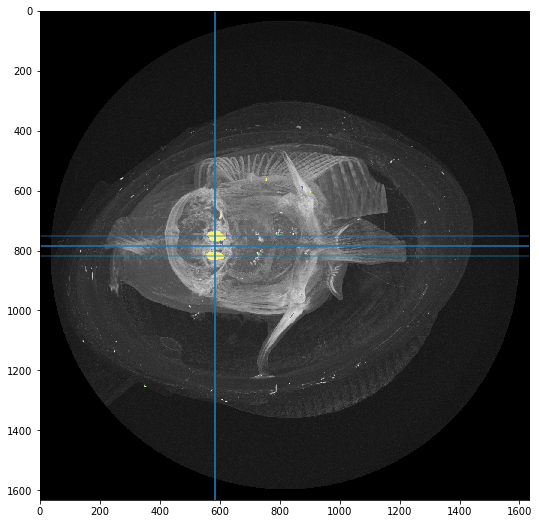

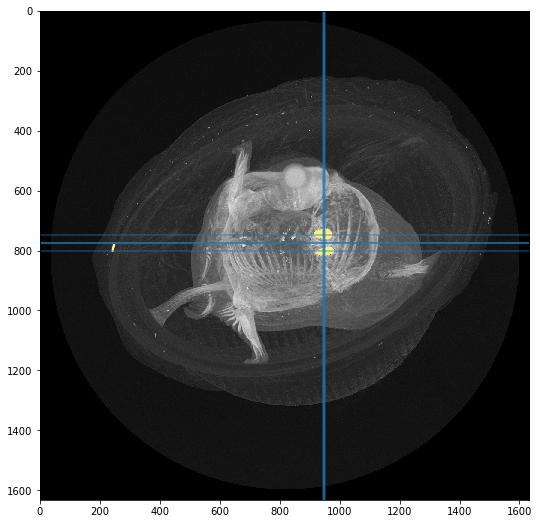

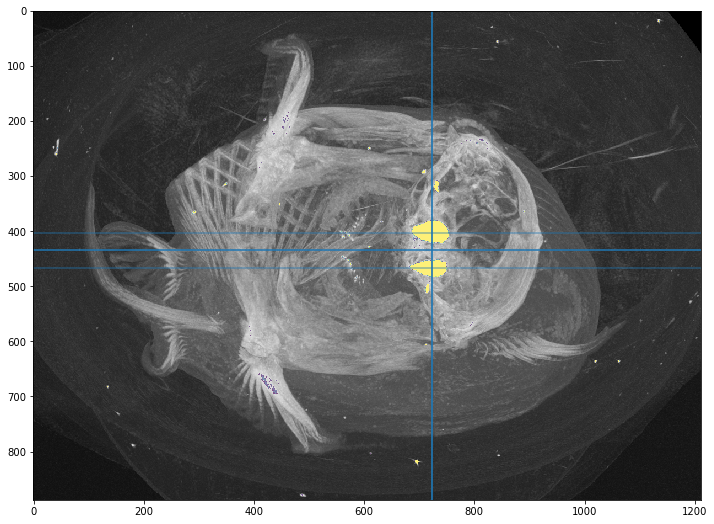

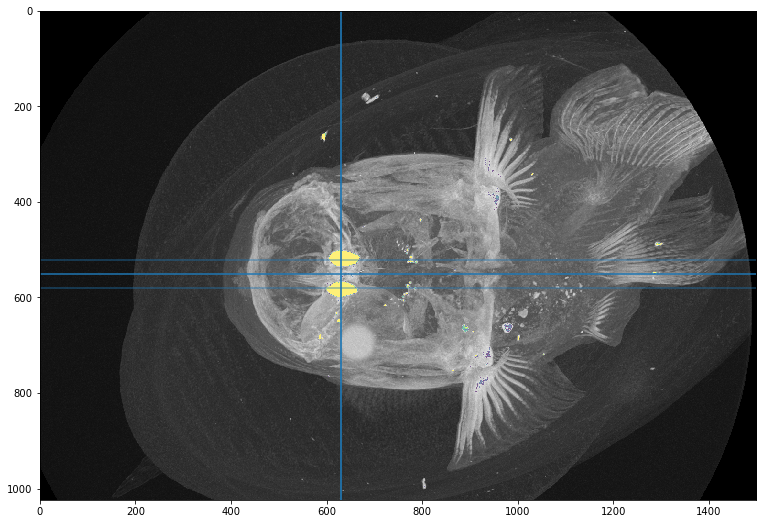

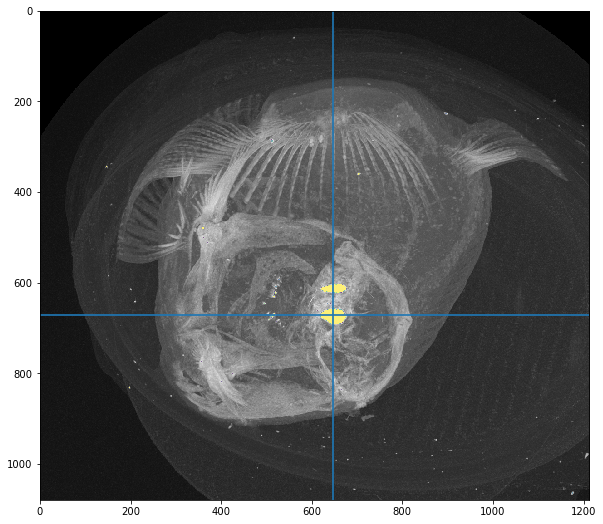

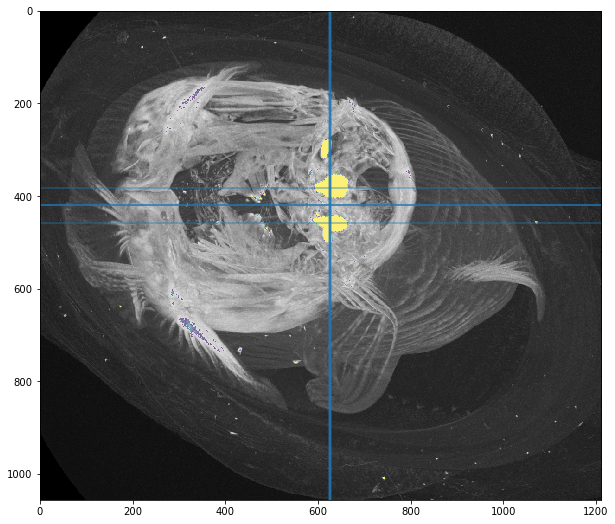

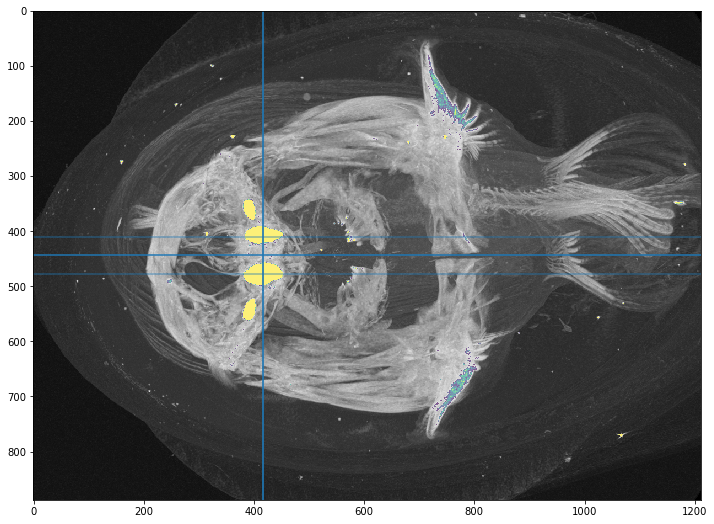

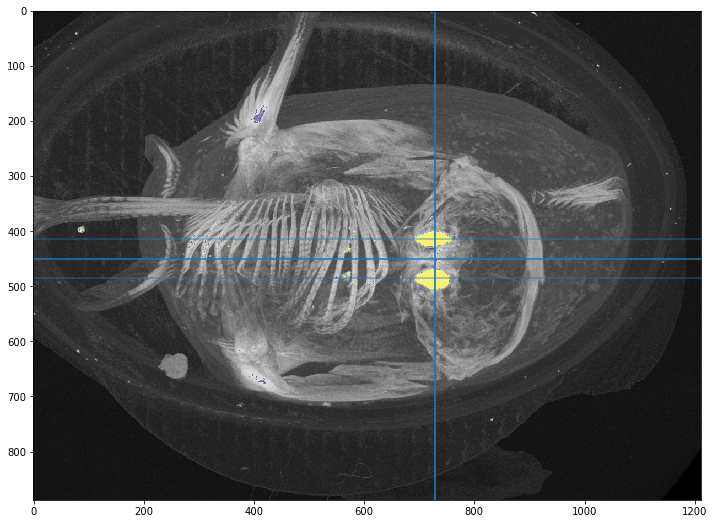

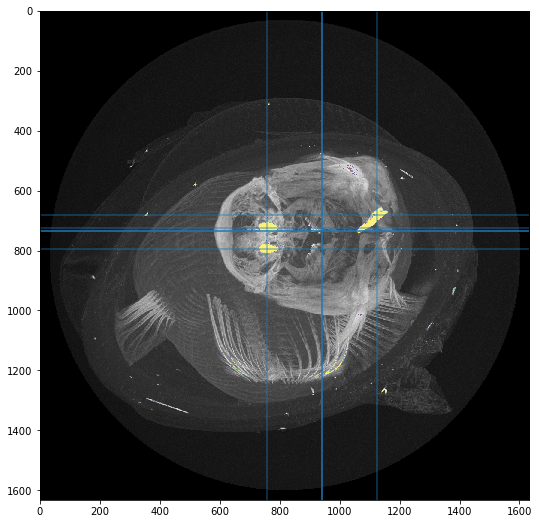

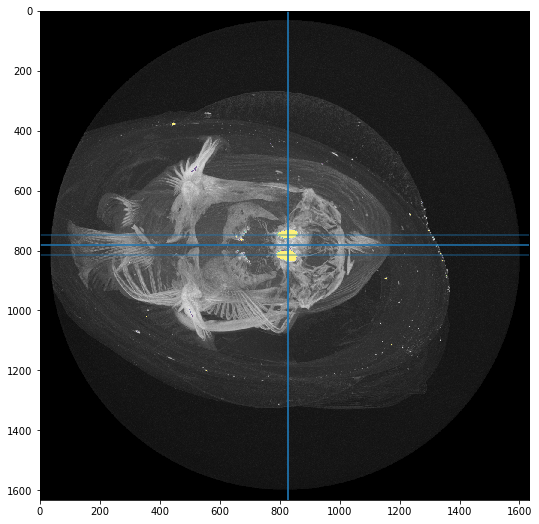

In [153]:
Data['Center_Axial'] = [otolither(m, verbose=True) for m in Data['MIP_Axial']]

In [154]:
Data

,LogFile,Folder,Sample,Experiment,Fish,Reconstructions,Number of reconstructions,Voxelsize,OutputNameRec,Size,Mid_Axial,Mid_Coronal,Mid_Sagittal,MIP_Axial,MIP_Coronal,MIP_Sagittal,Center_Axial
0,F:\Zebrafish_Carolina_Muscles\ko01\rec\ko01_re...,F:\Zebrafish_Carolina_Muscles\ko01\rec,ko01,KO,1,[F:\Zebrafish_Carolina_Muscles\ko01\rec\ko01_r...,4303,7.99995,F:\Zebrafish_Carolina_Muscles\ko01\ko01_rec.zarr,"(4303, 1632, 1632)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(583.0, 785.5)"
1,F:\Zebrafish_Carolina_Muscles\ko02\rec\ko02_re...,F:\Zebrafish_Carolina_Muscles\ko02\rec,ko02,KO,2,[F:\Zebrafish_Carolina_Muscles\ko02\rec\ko02_r...,3659,7.99995,F:\Zebrafish_Carolina_Muscles\ko02\ko02_rec.zarr,"(3659, 1632, 1632)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(949.0, 774.5)"
2,F:\Zebrafish_Carolina_Muscles\ko03\rec\ko03_re...,F:\Zebrafish_Carolina_Muscles\ko03\rec,ko03,KO,3,[F:\Zebrafish_Carolina_Muscles\ko03\rec\ko03_r...,3715,7.99995,F:\Zebrafish_Carolina_Muscles\ko03\ko03_rec.zarr,"(3715, 888, 1212)","[[4, 0, 0, 0, 0, 0, 2, 4, 7, 7, 3, 2, 1, 1, 6,...","[[35, 37, 35, 34, 33, 28, 23, 21, 22, 20, 19, ...","[[0, 0, 6, 9, 2, 0, 0, 2, 2, 0, 4, 4, 2, 0, 0,...","[[20, 19, 21, 19, 18, 18, 18, 22, 21, 19, 21, ...","[[16, 19, 15, 15, 15, 16, 17, 16, 15, 17, 16, ...","[[42, 42, 42, 40, 49, 43, 45, 40, 41, 50, 46, ...","(723.0, 434.5)"
3,F:\Zebrafish_Carolina_Muscles\ko04\rec\ko04_re...,F:\Zebrafish_Carolina_Muscles\ko04\rec,ko04,KO,4,[F:\Zebrafish_Carolina_Muscles\ko04\rec\ko04_r...,4303,7.99995,F:\Zebrafish_Carolina_Muscles\ko04\ko04_rec.zarr,"(4303, 1024, 1500)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[8, 6, 3, 0, 0, 7, 7, 0, 0, 0, 7, 13, 13, 9, ...","[[3, 8, 8, 6, 8, 9, 4, 0, 0, 0, 0, 0, 1, 2, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[16, 19, 16, 19, 19, 18, 23, 23, 20, 20, 19, ...","[[20, 19, 19, 25, 22, 24, 24, 22, 24, 21, 27, ...","(631.0, 551.0)"
4,F:\Zebrafish_Carolina_Muscles\ko05\rec\ko05_re...,F:\Zebrafish_Carolina_Muscles\ko05\rec,ko05,KO,5,[F:\Zebrafish_Carolina_Muscles\ko05\rec\ko05_r...,3361,7.99995,F:\Zebrafish_Carolina_Muscles\ko05\ko05_rec.zarr,"(3361, 1080, 1212)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[4, 7, 5, 0, 0, 0, 0, 0, 3, 6, 5, 1, 0, 1, 2,...","[[6, 6, 5, 7, 14, 14, 9, 10, 10, 6, 8, 6, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[26, 21, 22, 18, 19, 23, 21, 22, 22, 22, 20, ...","[[18, 20, 22, 20, 20, 21, 24, 21, 22, 21, 20, ...","(648.0, 671.0)"
5,F:\Zebrafish_Carolina_Muscles\wt01\rec\wt01_re...,F:\Zebrafish_Carolina_Muscles\wt01\rec,wt01,WT,1,[F:\Zebrafish_Carolina_Muscles\wt01\rec\wt01_r...,3846,7.99995,F:\Zebrafish_Carolina_Muscles\wt01\wt01_rec.zarr,"(3846, 1056, 1212)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[8, 4, 0, 0, 2, 0, 0, 16, 38, 36, 23, 15, 17,...","[[7, 3, 0, 0, 0, 0, 0, 0, 4, 7, 4, 0, 1, 6, 5,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[14, 16, 13, 13, 13, 14, 14, 15, 15, 12, 14, ...","[[16, 14, 15, 28, 49, 50, 52, 48, 42, 41, 44, ...","(626.3333333333334, 419.5)"
6,F:\Zebrafish_Carolina_Muscles\wt02\rec\wt02_re...,F:\Zebrafish_Carolina_Muscles\wt02\rec,wt02,WT,2,[F:\Zebrafish_Carolina_Muscles\wt02\rec\wt02_r...,4303,7.99995,F:\Zebrafish_Carolina_Muscles\wt02\wt02_rec.zarr,"(4303, 888, 1212)","[[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 4, 2, 0,...","[[26, 26, 28, 28, 27, 27, 21, 16, 15, 21, 22, ...","[[2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 4, 7, 8, 3, 0,...","[[16, 18, 19, 17, 23, 22, 19